In [ ]:
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, UpSampling2D, LeakyReLU, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, UpSampling2D, LeakyReLU, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Calculate class weights
def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        print(class_name)
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images_in_classes(train_dir)
num_classes = len(train_class_counts)
total_samples = sum(train_class_counts.values())

class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(train_class_counts.values())}
print("Class weights:", class_weights)

PNEUMONIA
NORMAL
COVID19
Class weights: {0: 0.5013342228152101, 1: 1.3564981949458483, 2: 3.729528535980149}


In [ ]:
import os
import shutil
import numpy as np

def split_data(source_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Ensure the ratios sum to 1
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1"

    # Create directories if they do not exist
    for directory in [train_dir, val_dir, test_dir]:
        os.makedirs(directory, exist_ok=True)
        for class_name in os.listdir(source_dir):
            os.makedirs(os.path.join(directory, class_name), exist_ok=True)

    # Split data
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        np.random.shuffle(images)

        train_split = int(train_ratio * len(images))
        val_split = int(val_ratio * len(images))

        train_images = images[:train_split]
        val_images = images[train_split:train_split + val_split]
        test_images = images[train_split + val_split:]

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

# Define paths
source_dir = '/content/drive/MyDrive/project'
train_dir = '/content/drive/MyDrive/train val test/train'
val_dir = '/content/drive/MyDrive/train val test/val'
test_dir = '/content/drive/MyDrive/train val test/test'

# Split data
split_data(source_dir, train_dir, val_dir, test_dir)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for validation and test data without data augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 4509 images belonging to 3 classes.
Found 965 images belonging to 3 classes.
Found 968 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Add L2 regularization
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.5),  # Add dropout for regularization
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Add L2 regularization
    BatchNormalization(),
    Dropout(0.5),# Add Batch Normalization
    Dense(3, activation='softmax')
])


58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
# Define callbacks
checkpoint = ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=1e-6)

callbacks = [checkpoint, lr_scheduler]

# Training configuration
epochs = 15
initial_learning_rate = 0.01
steps_per_epoch = len(train_generator)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Start training
start_time = datetime.now()

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks,class_weight=class_weights)

# Calculate training duration
training_duration = datetime.now() - start_time
print("Training duration:", training_duration)


Epoch 1/15
141/141 [==============================] - ETA: 0s - loss: 6.3496 - accuracy: 0.7112
Epoch 1: val_loss improved from inf to 3.80956, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


141/141 [==============================] - 116s 749ms/step - loss: 6.3496 - accuracy: 0.7112 - val_loss: 3.8096 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 2/15
141/141 [==============================] - ETA: 0s - loss: 3.7955 - accuracy: 0.8286
Epoch 2: val_loss improved from 3.80956 to 2.61105, saving model to model_checkpoint.h5
141/141 [==============================] - 112s 797ms/step - loss: 3.7955 - accuracy: 0.8286 - val_loss: 2.6111 - val_accuracy: 0.9098 - lr: 0.0010
Epoch 3/15
141/141 [==============================] - ETA: 0s - loss: 2.9049 - accuracy: 0.8385
Epoch 3: val_loss improved from 2.61105 to 2.04482, saving model to model_checkpoint.h5
141/141 [==============================] - 113s 796ms/step - loss: 2.9049 - accuracy: 0.8385 - val_loss: 2.0448 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 4/15
141/141 [==============================] - ETA: 0s - loss: 2.3761 - accuracy: 0.8525
Epoch 4: val_loss improved from 2.04482 to 1.71634, saving model to model_checkpoint.h5
141/

In [ ]:


# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

31/31 [==============================] - 14s 438ms/step - loss: 0.7354 - accuracy: 0.9287
Test Accuracy: 0.9287189841270447


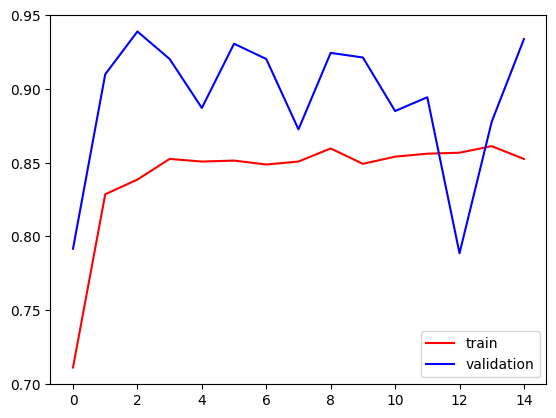

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

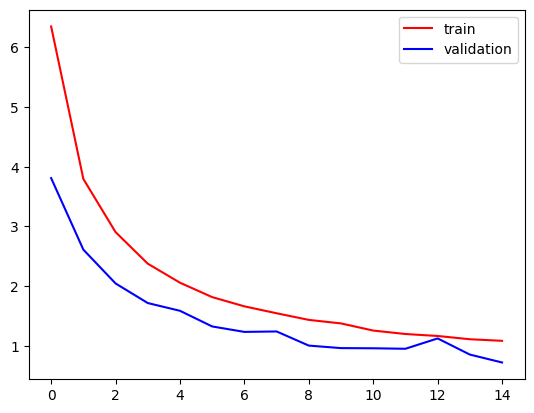

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

31/31 [==============================] - 12s 390ms/step - loss: 0.7354 - accuracy: 0.9287
Test Loss: 0.735359787940979
Test Accuracy: 0.9287189841270447


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have already trained your model and loaded test data

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_generator)

# Predict classes for training set
train_predictions = model.predict(train_generator)
train_predicted_classes = np.argmax(train_predictions, axis=1)

# Get true labels for training set
train_true_classes = train_generator.classes

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Generate classification report for training set
train_report = classification_report(train_true_classes, train_predicted_classes, target_names=class_labels)

print("Training Classification Report:")
print(train_report)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Predict classes for validation set
test_predictions = model.predict(test_generator)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Get true labels for validation set
test_true_classes = test_generator.classes

# Generate classification report for validation set
test_report = classification_report(test_true_classes, test_predicted_classes, target_names=class_labels)

print("test Classification Report:")
print(test_report)


141/141 [==============================] - 100s 706ms/step
Training Classification Report:
              precision    recall  f1-score   support

     COVID19       0.11      0.10      0.10       403
      NORMAL       0.28      0.18      0.21      1108
   PNEUMONIA       0.67      0.77      0.72      2998

    accuracy                           0.56      4509
   macro avg       0.35      0.35      0.35      4509
weighted avg       0.53      0.56      0.54      4509

31/31 [==============================] - 12s 390ms/step
test Classification Report:
              precision    recall  f1-score   support

     COVID19       0.10      0.11      0.11        87
      NORMAL       0.22      0.18      0.19       238
   PNEUMONIA       0.66      0.68      0.67       643

    accuracy                           0.51       968
   macro avg       0.32      0.33      0.32       968
weighted avg       0.50      0.51      0.50       968

